# Mask Detection

## Dependencies

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

# Import the dependencies.
# OpenCV
import cv2

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model, load_model

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow Libraries Matter for Speed!!!
print(tf.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

1.14.0


C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

# Data Loading

In [2]:
# All this could be coverted to the pathlib module
# 

# Processed folder houses the already seperated image files
# Images are sperated into two categories "without_mask" & "with_mask"
# Grab the location of the processed folder
data_path = "../data/processed"

# grab the two folder groups and make them to categories
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

# Initialize an empty dictionary for labels
label_dict = dict(zip(categories, labels))

print(f"Printing the labels'dict' {label_dict}")
print(f"Printing the categories'list' {categories}")
print(f"Printing the labels as digits {labels}")

Printing the labels'dict' {'without_mask': 0, 'with_mask': 1}
Printing the categories'list' ['without_mask', 'with_mask']
Printing the labels as digits [0, 1]


# Data Preprocessing

In [3]:
# Normalizing all images to the same size 300x300
img_size = 100
# List 
data = []
target = []

# Looping through the processed folder grabing each image
# processing that image through cv2 to gray scale and demension
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            # Coverting the image into gray scale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Resizing the gray scale into 300x300, since we need a fixed common size for all the images in the dataset
            resized = cv2.resize(gray, (img_size, img_size))
            # Appending the image and the label(categorized) into the list (dataset)
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            # If any exception rasied, the exception will be printed here. And pass to the next image
            print("Exception:", e)

In [4]:
# Create a numpy array to store data and target
# Normalize data
data = np.array(data) / 255.0

data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)

# Use the keras utils tool to create catagorical target
new_target = tf.keras.utils.to_categorical(target)

In [5]:
# https://numpy.org/doc/stable/reference/generated/numpy.save.html
np.save("numpy/data", data)
np.save("numpy/target", new_target)

# Training the Convolutional Neural Network

In [6]:
# Loading in the saved numpy arrays in the previous code
data = np.load("numpy/data.npy")
target = np.load("numpy/target.npy")
print(data.shape[1:])

(300, 300, 1)


In [10]:
# Create the model
model = Sequential()

# The first CNN layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# The second convolution layer followed by Relu and MaxPooling layers
model.add(layers.Conv2D(100, (3, 3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to stack the output convolutions from second convolution layer
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

# Dense layer of 64 neurons
model.add(layers.Dense(64, activation="relu"))
# The Final layer with two outputs for two categories
model.add(layers.Dense(2, activation="softmax"))

# Compile the model
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [11]:
from sklearn.model_selection import train_test_split

# Use the train_test_split to split the data into training and testing set.
# The data set isnt very large so only using 10% to test.
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.1
)

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoints/model-{epoch:03d}.model",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
)
history = model.fit(
    train_data, train_target, epochs=20, callbacks=[checkpoint], validation_split=0.2
)

Train on 2782 samples, validate on 696 samples
Epoch 1/20
2782/2782 [==============================] - 566s 203ms/sample - loss: 0.8437 - acc: 0.6571 - val_loss: 0.4912 - val_acc: 0.7644
Epoch 2/20
2782/2782 [==============================] - 553s 199ms/sample - loss: 0.4375 - acc: 0.7994 - val_loss: 0.3614 - val_acc: 0.8434
Epoch 3/20
2782/2782 [==============================] - 517s 186ms/sample - loss: 0.3600 - acc: 0.8393 - val_loss: 0.3521 - val_acc: 0.8434
Epoch 4/20
2782/2782 [==============================] - 518s 186ms/sample - loss: 0.2761 - acc: 0.8774 - val_loss: 0.3289 - val_acc: 0.8491
Epoch 5/20
2782/2782 [==============================] - 511s 184ms/sample - loss: 0.2086 - acc: 0.9109 - val_loss: 0.3295 - val_acc: 0.8606
Epoch 6/20
2782/2782 [==============================] - 509s 183ms/sample - loss: 0.1400 - acc: 0.9418 - val_loss: 0.5219 - val_acc: 0.8376
Epoch 7/20
2782/2782 [==============================] - 509s 183ms/sample - loss: 0.0942 - acc: 0.9608 - val_loss

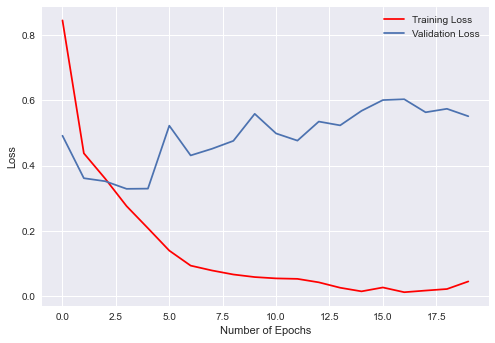

In [13]:
# Chart of What?
# Defined style for plot
plt.style.use('seaborn')
plt.plot(history.history["loss"], "r", label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/loss.png")
plt.show()

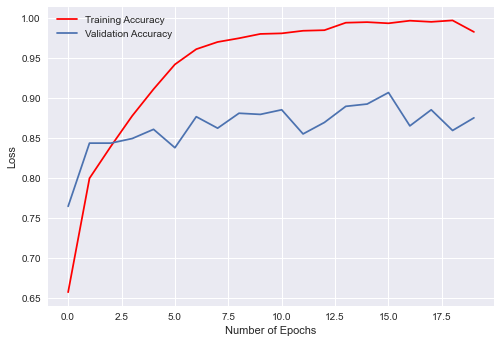

In [14]:
# Another Chart of what
# Defined style for plot
plt.style.use('seaborn')
plt.plot(history.history["acc"], "r", label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/accuracy.png")
plt.show()

In [15]:
print(model.summary())
print(model.evaluate(test_data, test_target))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 298, 298, 200)     2000      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 149, 149, 200)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 147, 147, 100)     180100    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 73, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 532900)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 532900)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [18]:
# Properly save the model for API use.
tf.keras.models.save_model(
    model,
    "model_checkpoints/model",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    #signatures=None,
    #options=None
)

# Detecting Masks

 - Install nodeJS
 - pip install ipywidgets
 - jupyter nbextension enable --py widgetsnbextension
 - jupyter labextension install @jupyter-widgets/jupyterlab-manager
 - (may need to restart your lab)

In [19]:
# Load in once of the well performing models from the checkpoints directory.
model = load_model("./model_checkpoints/model-009.model")
# Load in the face detection classifier for CV2
face_clsfr = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Label and color in RGB for the frame
labels_dict = {0: "Yes", 1: "No"}
color_dict = {0: (0, 255, 0), 1: (0, 0, 255)}

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
test_path_one = "../data/external/test/maksssksksss0.png"
test_path_two = "../data/external/test/maksssksksss273.png"
test_path_three = "../data/external/test/maksssksksss299.png"

# Prediction Function
# Needs to be CONVERTED to an API style module.
# Generate a prediction with loaded model
def predictor(requestedImage):
    img = cv2.imread(requestedImage)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:

        # Find face, resize the shape, pass into model
        face_img = gray[y : y + w, x : x + w]
        resized = cv2.resize(face_img, (100, 100))
        normalized = resized / 255.0
        reshaped = np.reshape(normalized, (1, 100, 100, 1))
        result = model.predict(reshaped)

        label = np.argmax(result, axis=1)[0]

        # Draw the rectangle around the face of the person in frame
        # Passed in the color and text dicts from the previous cell
        cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[label], 2)
        cv2.rectangle(img, (x, y - 40), (x + w, y), color_dict[label], -1)
        cv2.putText(
            img,
            labels_dict[label],
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 255, 255),
            2,
        )
    
    # show the image
    cv2.imshow('mask detection', img)
    # keep the window open until we press a key
    cv2.waitKey(0)
    # close the window
    cv2.destroyAllWindows()

# Test the prediction fucntion
predictor(test_path_three)
    
# Input for file selction
# https://stackoverflow.com/a/64804255/1330405
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html?highlight=FileUpload#File-Upload
from ipywidgets import FileUpload
from IPython.display import display

# Print all the details for the image uploaded.
def on_upload_change(change):
    if change.new==0:
        print ('cleared')
        return
    up = change.owner
    print (type(up.value))
    for filename,data in up.value.items():
        print('==========================================================================================')
        print(filename)
        for k,v in data['metadata'].items():
            print(f'    -{k:13}:[{v}]')
        print(f'    -content len  :[{len(data["content"])}]')
        print('==========================================================================================')
    up.value.clear()
    up._counter = 0

upload_btn = FileUpload(
    accept='image/*',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
display(upload_btn)
upload_btn.observe(on_upload_change, names='_counter')

print(upload_btn.value)

FileUpload(value={}, accept='image/*', description='Upload')

{}


In [ ]:
# Wanting to try and implent the same but with HTML and JavaScript
from IPython.display import display, HTML

display(HTML("""
    <input type="file" name="myfile">
"""))